# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

## Group Number : 25

## Student 1 
### Name : Aditya Kunar
### ID : 5074274

## Student 2
### Name : Anwesh Marwade
### ID : 5052068

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import re
from random import randint
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

### Read the Data

In [2]:
data = "data_for_student_case.csv" #modify the path here for wherever the data is.
df1 = pd.read_csv(data)

### A look at the data

In [3]:
df1.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


### Data Preprocessing

In [4]:
# Apply currency conversion so that the amounts are standardized
def conv(row):
    currency_dict = {0: 0.86248, 1: 1.5911, 2: 21.2829, 3: 1.6805, 4: 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

def preprocess(df):
    
    df1 = df.copy(deep=True)
    df1 = df1.loc[~(df1['simple_journal'] == 'Refused')] #removing the unknown class.
    df1.loc[df1['simple_journal'] == 'Chargeback', 'simple_journal'] = 1 #fraud
    df1.loc[df1['simple_journal'] == 'Settled', 'simple_journal'] = 0 #Normal
    
    #Dealing with na values by filling them with default values. 
    df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
    df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
    df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'
    df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'
    #3-6 is just 3 for cvcresponsecode.
    df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3
    
    #Encoding the categorical variables.
    bin_enc = LabelEncoder()
    bin_enc.fit(df1['bin'].unique())
    df1['bin'] = bin_enc.transform(df1.bin)

    card_enc = LabelEncoder()
    card_enc.fit(df1['card_id'])
    df1['card_id'] = card_enc.transform(df1.card_id)

    ip_enc = LabelEncoder()
    ip_enc.fit(df1['ip_id'])
    df1['ip_id'] = ip_enc.transform(df1.ip_id)

    unique_issuer_cc = df1['issuercountrycode'].unique()
    unique_shopper_cc = df1['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
    df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)
    
    enc1 = LabelEncoder()
    enc1.fit(df1['txvariantcode'])
    df1['txvariantcode'] = enc1.transform(df1.txvariantcode)

    enc2 = LabelEncoder()
    enc2.fit(df1['currencycode'])
    df1['currencycode'] = enc2.transform(df1.currencycode)

    enc3 = LabelEncoder()
    enc3.fit(df1['shopperinteraction'])
    df1['shopperinteraction'] = enc3.transform(df1.shopperinteraction)

    enc4 = LabelEncoder()
    enc4.fit(df1['accountcode'])
    df1['accountcode'] = enc4.transform(df1.accountcode)

    enc5 = LabelEncoder()
    enc5.fit(df1['cardverificationcodesupplied'])
    df1['cardverificationcodesupplied'] = enc5.transform(df1.cardverificationcodesupplied)
    
    df1['creationdate'] = pd.to_datetime(df1['creationdate'])
    df1['date'] = df1['creationdate'].dt.date
        
    enc6 = LabelEncoder()
    enc6.fit(df1['mail_id'])
    df1['mail_id'] = enc6.transform(df1.mail_id)

    df1['bookingdate'] = pd.to_datetime(df1['bookingdate'])

    df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
    df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
    df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

    df1['day_of_week'] = df1['creationdate'].dt.dayofweek

    df1['hour'] = df1['creationdate'].dt.hour
    
    dates= df1["creationdate"]
    dates=pd.DatetimeIndex(dates)
    dates=dates.astype(np.int64) // 10**9
    df1['creationdate_Unix']=dates
    
    df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)
    
    return df1



In [5]:
df = preprocess(df1)

In [6]:
df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,...,accountcode,mail_id,ip_id,card_id,date,countries_equal,day_of_week,hour,creationdate_Unix,amount_eur
0,1,2015-11-09 14:26:51,104,2,1998,64800.0,2,104,1,1,...,1,187702,7386,73358,2015-07-01,1,2,23,1435791791,30.446979
1,2,2015-11-09 14:27:38,104,2,2364,44900.0,2,104,1,1,...,1,834,194109,44739,2015-07-02,1,3,4,1435812655,21.096749
2,3,2015-11-23 16:34:16,104,2,1965,149900.0,2,104,1,1,...,1,119287,189655,122802,2015-07-02,1,3,14,1435847428,70.432131
3,4,2015-11-23 16:34:51,104,2,2374,109900.0,2,104,1,1,...,1,173561,8254,70712,2015-07-03,1,4,7,1435910017,51.637700
4,5,2015-11-09 14:26:08,104,6,1301,89900.0,2,104,1,1,...,1,70647,196247,208481,2015-07-08,1,2,18,1436380535,42.240484


In [7]:
df_notswapped = df.drop(columns=['txid','creationdate','bookingdate','amount','date'])

In [8]:
#Technically rank-swapping is for ordinal values. That is basically date and amount in euros.
#But if you wish, it can be done for the rest.
def rank_swap(perc,column,df):
    p = perc
    c = column
    sortbycol = df.sort_values(c)
    sortedbycolindex=sortbycol.index.to_list()
    interval = int(len(df.index)*(p/100))
    value_list=set()
    for i in range(len(sortedbycolindex)):
        if i in value_list:
            continue        
        value = randint(0,len(sortedbycolindex)-1)
        while(abs(i-value)>interval):
            value = randint(0,len(sortedbycolindex)-1)
        value_list.add(value)    
        sortedbycolindex[i], sortedbycolindex[value] = sortedbycolindex[value], sortedbycolindex[i]
    
    newdf=df.reindex(sortedbycolindex)  
    v=newdf[c]
    df[c]=v.values
    if c=="amout_eur":
        currencycode=newdf["currencycode"]
        df["currencycode"]=currencycode.values
        
    return df    
    

In [9]:
#Only those with ordinal component.
df.drop(columns=['txid','creationdate','bookingdate','amount','date'],inplace=True)
df = rank_swap(10,"amount_eur",df)
df = rank_swap(10,"creationdate_Unix",df)
df = rank_swap(10,"day_of_week",df)
df = rank_swap(10,"hour",df)
df_swapped= df

In [68]:
#swapping every column.
for i in df.columns:
    df=rank_swap(10,i,df)

In [69]:
df_swapped=df

In [70]:
df1= df_notswapped
df2= df_swapped

In [82]:
df1.drop(columns=['issuercountrycode','bin','shoppercountrycode','mail_id', 'ip_id', 'card_id'],inplace=True)
df2.drop(columns=['issuercountrycode','bin','shoppercountrycode','mail_id', 'ip_id', 'card_id'],inplace=True)


In [83]:
X1 = df1.drop(columns="simple_journal")
y1 = df1["simple_journal"]
X2 = df2.drop(columns="simple_journal")
y2 = df2["simple_journal"]
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X2 = scaler.fit_transform(X2)



In [84]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,stratify=y1,test_size=0.33)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,stratify=y2,test_size=0.33)

Number of mislabeled points out of a total 78222 points : 11533
accuracy:  0.8525606606836951
Number of mislabeled points out of a total 78222 points : 26735
accuracy:  0.6582163585692005


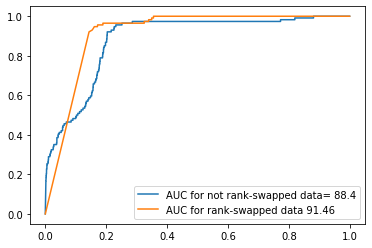

((66622, 11486, 47, 67), (51375, 26733, 2, 112))

In [89]:
gnb = GaussianNB()

y1_pred = gnb.fit(X1_train, y1_train).predict(X1_test)
print("Number of mislabeled points out of a total %d points : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

y1_pred_proba = gnb.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC for not rank-swapped data= " +str(round(auc1*100,2)))

y2_pred = gnb.fit(X2_train, y2_train).predict(X2_test)
print("Number of mislabeled points out of a total %d points : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

y2_pred_proba = gnb.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC for rank-swapped data " +str(round(auc2*100,2)))

plt.legend(loc=4)
plt.show()

tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()

(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2)

Number of mislabeled points out of a total 78222 points : 528
accuracy:  0.9932499808238091
Number of mislabeled points out of a total 78222 points : 175
accuracy:  0.997762777735164


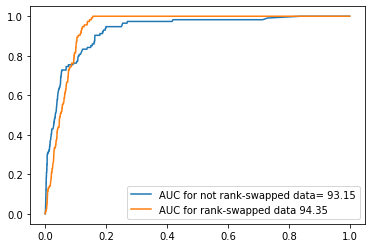

((77665, 443, 85, 29), (78046, 62, 113, 1))

In [90]:
clf = RandomForestClassifier(max_depth=2, random_state=0)

y1_pred = clf.fit(X1_train, y1_train).predict(X1_test)
print("Number of mislabeled points out of a total %d points : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

y1_pred_proba = clf.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC for not rank-swapped data= " +str(round(auc1*100,2)))

y2_pred = clf.fit(X2_train, y2_train).predict(X2_test)
print("Number of mislabeled points out of a total %d points : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

y2_pred_proba = clf.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC for rank-swapped data " +str(round(auc2*100,2)))

plt.legend(loc=4)
plt.show()

tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()

(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2)

Number of mislabeled points out of a total 78222 points : 2049
accuracy:  0.9738053233105776
Number of mislabeled points out of a total 78222 points : 3448
accuracy:  0.9559203293191174


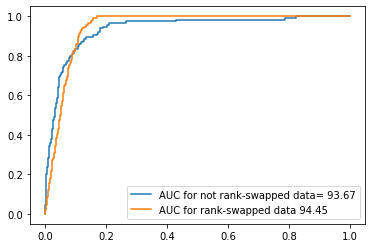

((76123, 1985, 64, 50), (74725, 3383, 65, 49))

In [91]:
clf = LogisticRegression(random_state=0)

y1_pred = clf.fit(X1_train, y1_train).predict(X1_test)
print("Number of mislabeled points out of a total %d points : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

y1_pred_proba = clf.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC for not rank-swapped data= " +str(round(auc1*100,2)))

y2_pred = clf.fit(X2_train, y2_train).predict(X2_test)
print("Number of mislabeled points out of a total %d points : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

y2_pred_proba = clf.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC for rank-swapped data " +str(round(auc2*100,2)))

plt.legend(loc=4)
plt.show()


tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()

(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2)

In [88]:
#subsampling
posindex=[]
for i in enumerate(y1_train):
    if i[1]==1:
        posindex.append(i[0])
fullindex=list(range(0,len(y1_train)))
sampleindex= list(set(fullindex)-set(posindex))
randomlist = random.sample(range(0, len(sampleindex)),2079)
randomlist.extend(posindex)
X1_train=(X1_train[randomlist])
y1_train=np.array(y1_train)
y1_train=y1_train[randomlist]
posindex=[]
for i in enumerate(y2_train):
    if i[1]==1:
        posindex.append(i[0])
fullindex=list(range(0,len(y2_train)))
sampleindex= list(set(fullindex)-set(posindex))
randomlist = random.sample(range(0, len(sampleindex)),2079)
randomlist.extend(posindex)
X2_train=(X2_train[randomlist])
y2_train=np.array(y2_train)
y2_train=y2_train[randomlist]
